In [1]:
%%capture
# Restart the runtime before running this cell
import popv
import numpy as np
import scanpy as sc
import os

2023-02-07 00:22:37.745266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 00:22:37.855076: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 00:22:38.439465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-02-07 00:22:38.439537: W tensorflow/compiler/xla/stream_executor/platf

In [2]:
import requests
res = requests.get("https://zenodo.org/api/records/7587774")
tissue_download_path = {ind['key'][3:-14]:ind['links']['self'] for ind in res.json()['files']}

In [14]:
# read in the reference dataset
output_fn = 'Thymus_TS.h5ad'
ref_adata = sc.read_h5ad(output_fn)
# ref_adata = ref_adata[np.random.choice(ref_adata.obs_names, 5000, replace=False)]

In [ ]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [5]:
sc.experimental.pp.highly_variable_genes(ref_adata, n_top_genes=5000, subset=False)
sc.pp.normalize_total(ref_adata)
sc.pp.log1p(ref_adata)
ref_adata.raw = ref_adata.copy()
ref_adata = ref_adata[:, ref_adata.var['highly_variable']]
sc.tl.pca(ref_adata, n_comps=30)

In [6]:
ref_adata

AnnData object with n_obs × n_vars = 33661 × 5000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'variances', 'residual_variances', 'highly_variable_rank'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    varm: 'PCs'

In [7]:
sc.external.pp.harmony_integrate(ref_adata, 'donor_assay', basis='X_pca', adjusted_basis='X_pca_harmony', nclust=30)

2023-02-05 21:24:44,849 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-02-05 21:24:57,512 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-02-05 21:24:57,610 - harmonypy - INFO - Iteration 1 of 10
2023-02-05 21:24:59,596 - harmonypy - INFO - Iteration 2 of 10
2023-02-05 21:25:01,616 - harmonypy - INFO - Iteration 3 of 10
2023-02-05 21:25:03,526 - harmonypy - INFO - Iteration 4 of 10
2023-02-05 21:25:04,487 - harmonypy - INFO - Iteration 5 of 10
2023-02-05 21:25:05,277 - harmonypy - INFO - Converged after 5 iterations


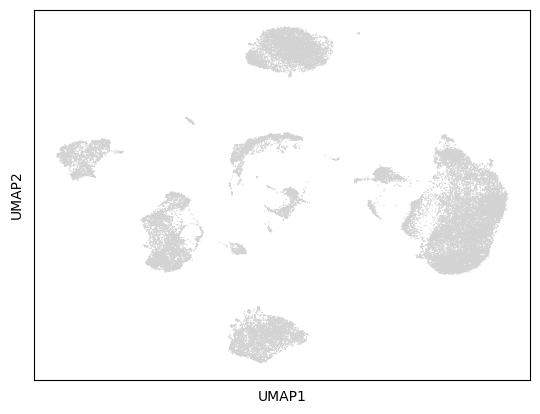

In [8]:
sc.pp.neighbors(ref_adata, use_rep='X_pca_harmony')
sc.tl.umap(ref_adata, min_dist=0.2)
sc.pl.umap(ref_adata)

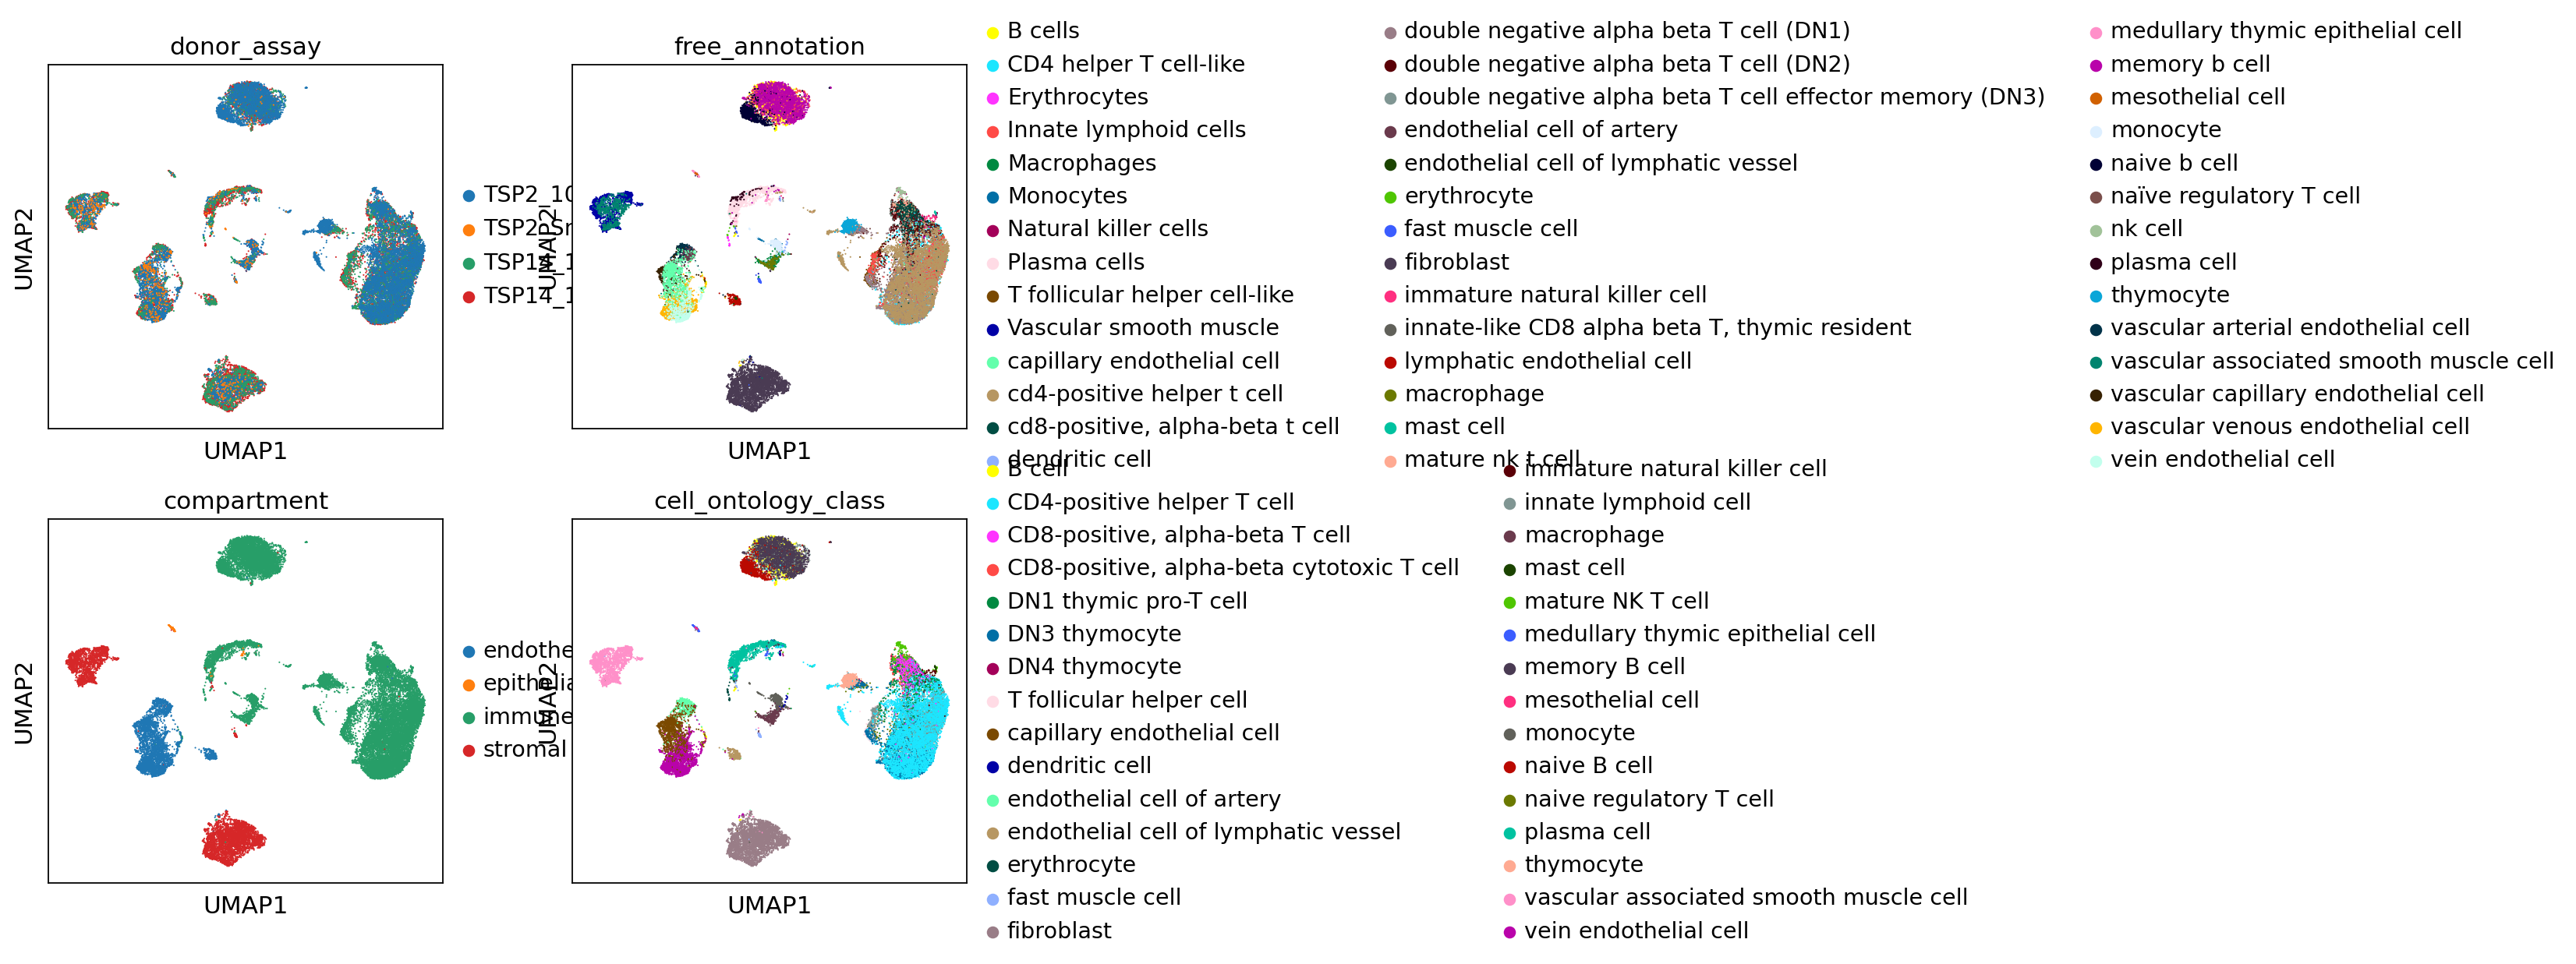

In [9]:
sc.set_figure_params(figsize=None)
sc.pl.umap(ref_adata, color=['donor_assay', 'free_annotation', 'compartment', 'cell_ontology_class'], ncols=2)

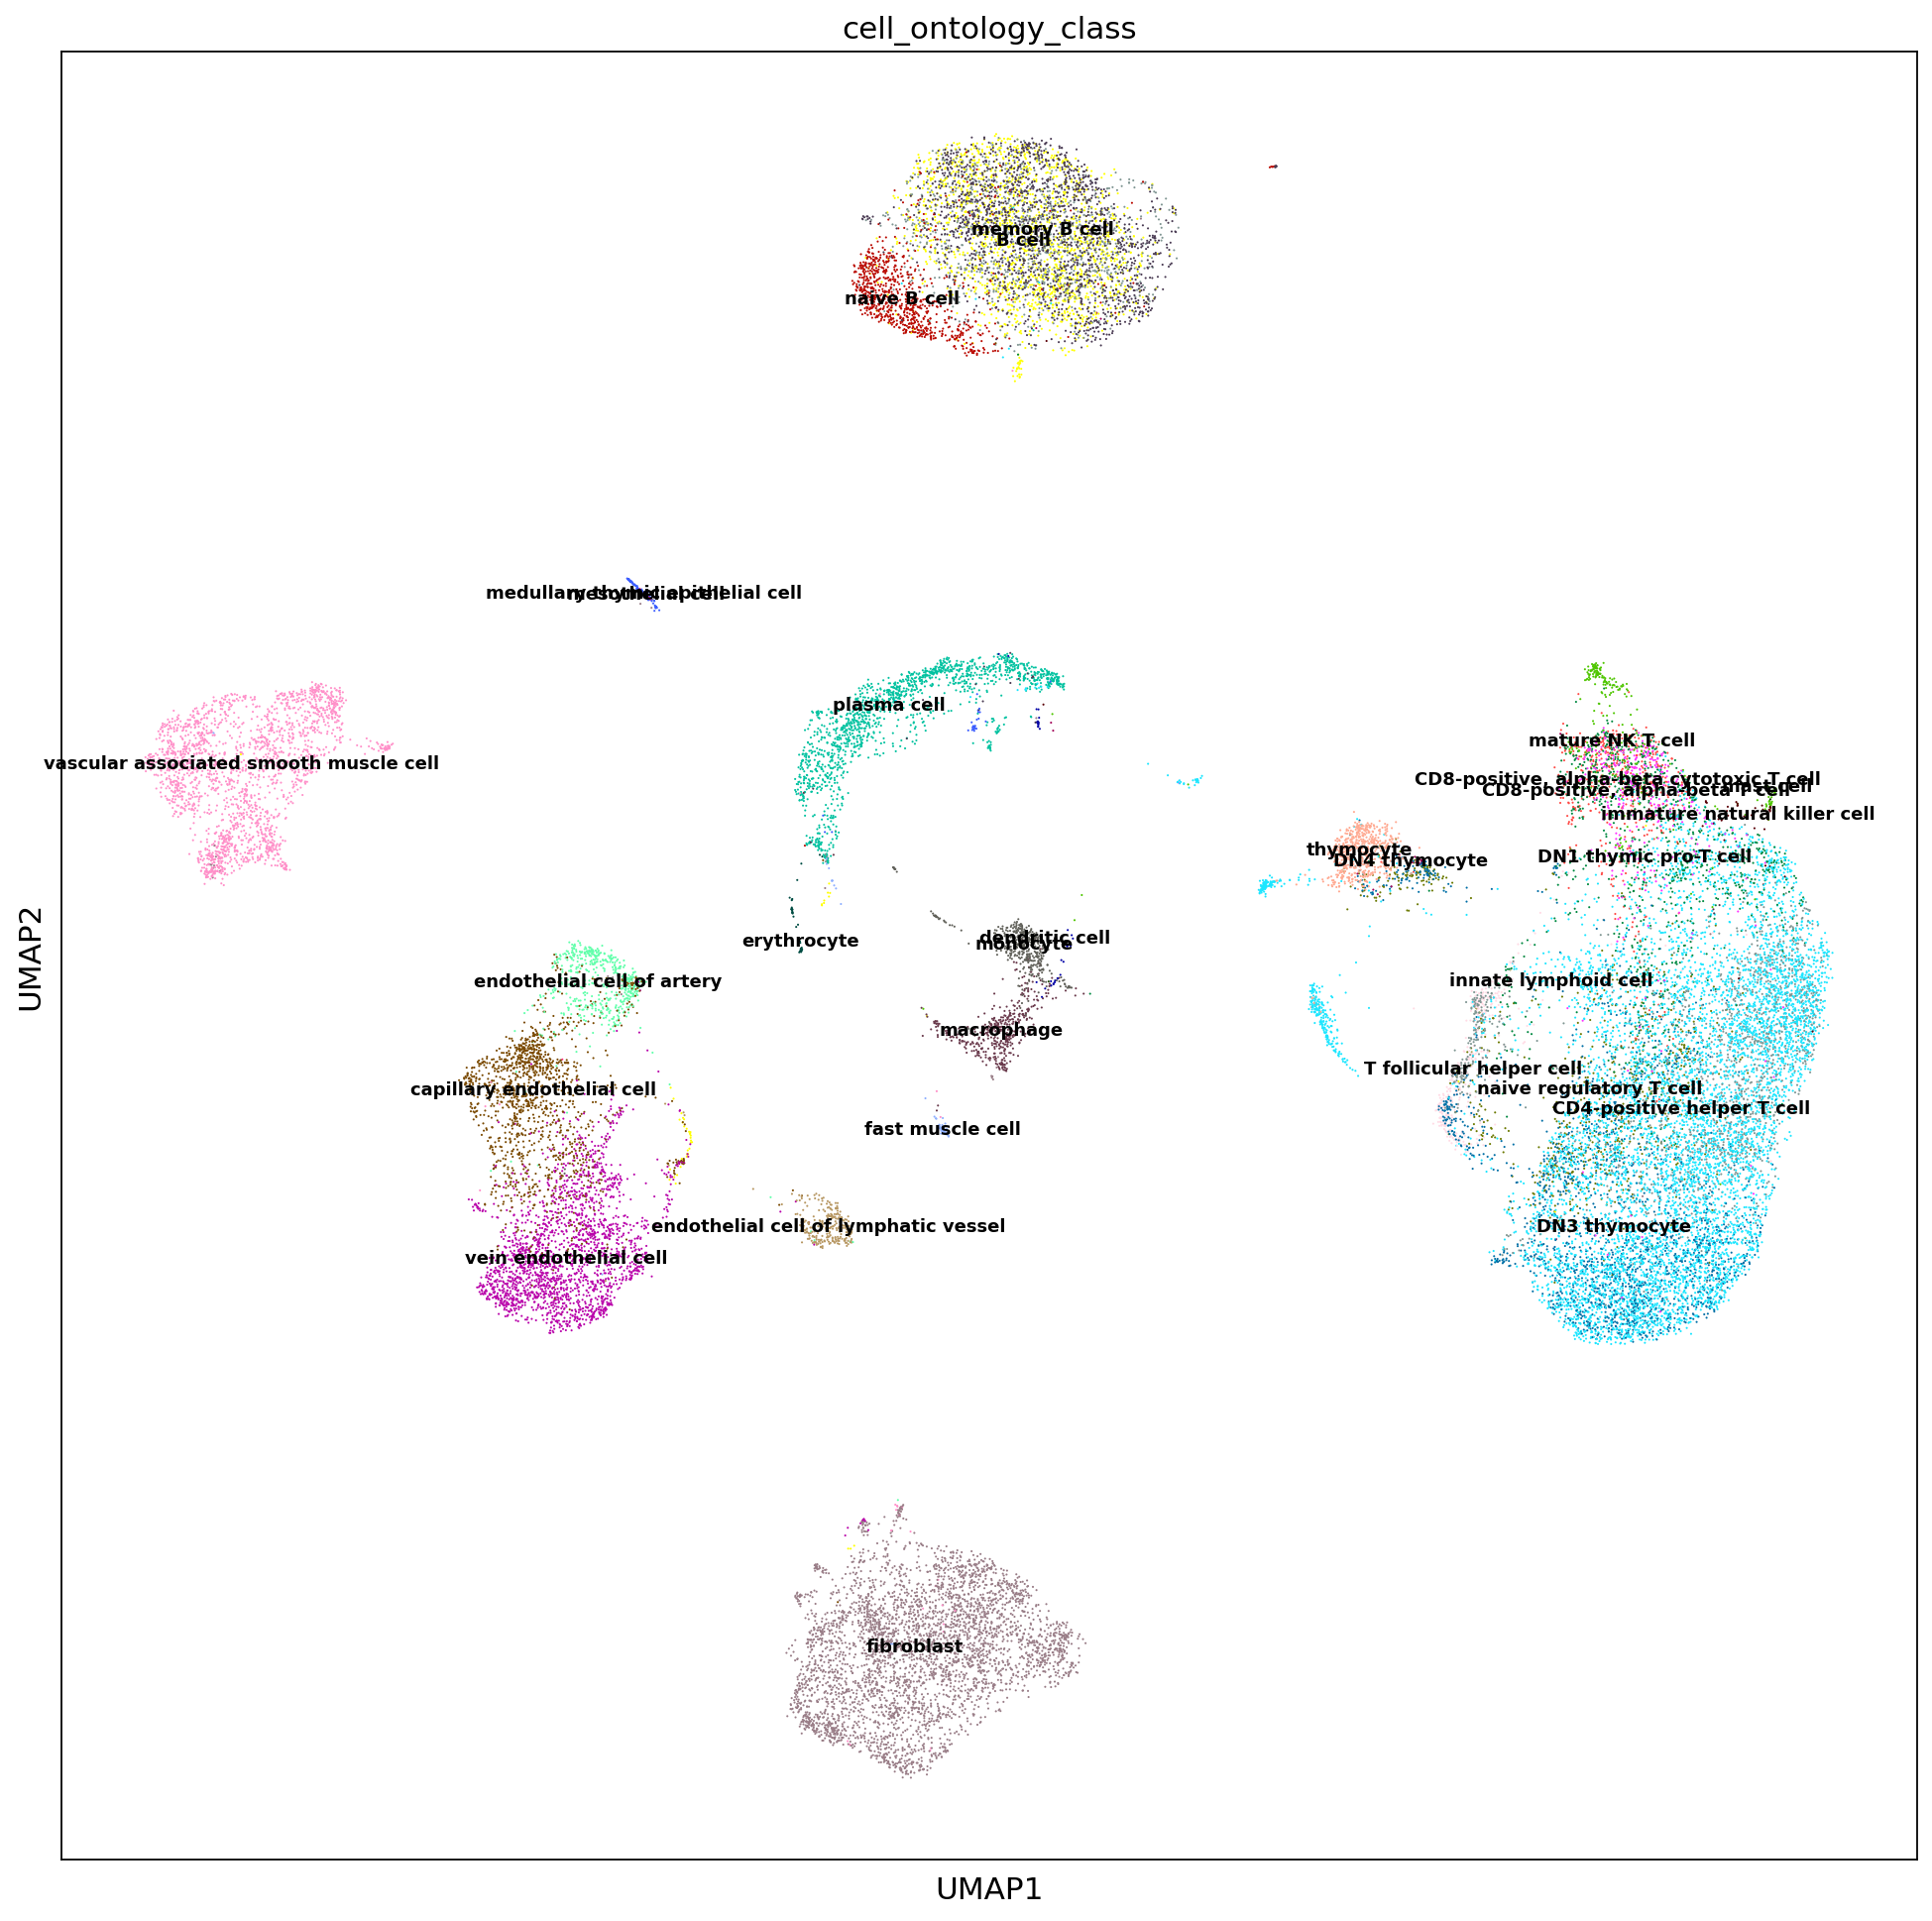

In [10]:
sc.set_figure_params(figsize=[15, 15])
sc.pl.umap(ref_adata, color='cell_ontology_class', legend_loc='on data', legend_fontsize='xx-small')

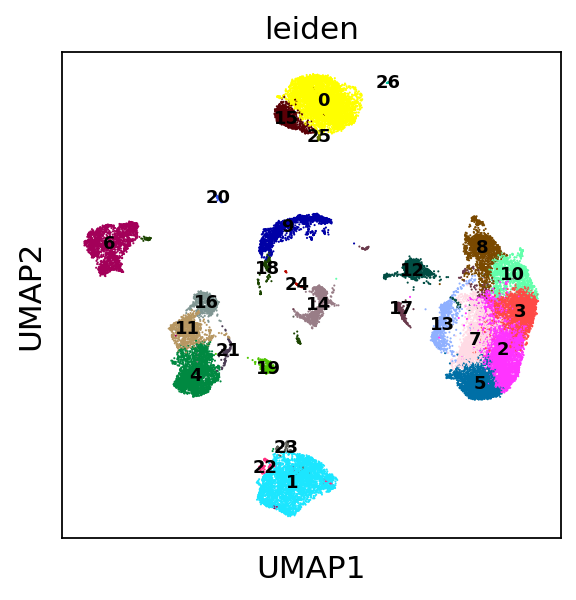

In [14]:
sc.set_figure_params(figsize=None)
sc.tl.leiden(ref_adata, resolution=1.0)
sc.pl.umap(ref_adata, color='leiden', legend_loc='on data', legend_fontsize='xx-small')

In [28]:
ref_adata = sc.read('reannotated_thymus.h5ad')

In [ ]:
sc.tl.rank_genes_groups(ref_adata, groupby='leiden')
sc.pl.rank_genes_groups(ref_adata)

In [43]:
sc.tl.leiden(ref_adata, restrict_to=['leiden', [10, 8, 12, 14]], resolution=1.0, key_added='leiden_sub')

'B cell, CD4-positive helper T cell, CD8-positive, alpha-beta T cell, CD8-positive, alpha-beta cytotoxic T cell, DN1 thymic pro-T cell, DN3 thymocyte, DN4 thymocyte, T follicular helper cell, capillary endothelial cell, dendritic cell, endothelial cell of artery, endothelial cell of lymphatic vessel, erythrocyte, fast muscle cell, fibroblast, immature natural killer cell, innate lymphoid cell, macrophage, mast cell, mature NK T cell, medullary thymic epithelial cell, memory B cell, mesothelial cell, monocyte, naive B cell, naive regulatory T cell, plasma cell, thymocyte, vascular associated smooth muscle cell, vein endothelial cell'

In [36]:
sc.tl.leiden(ref_adata, restrict_to=['leiden_sub', ['9']], resolution=0.2, key_added='leiden_sub2')

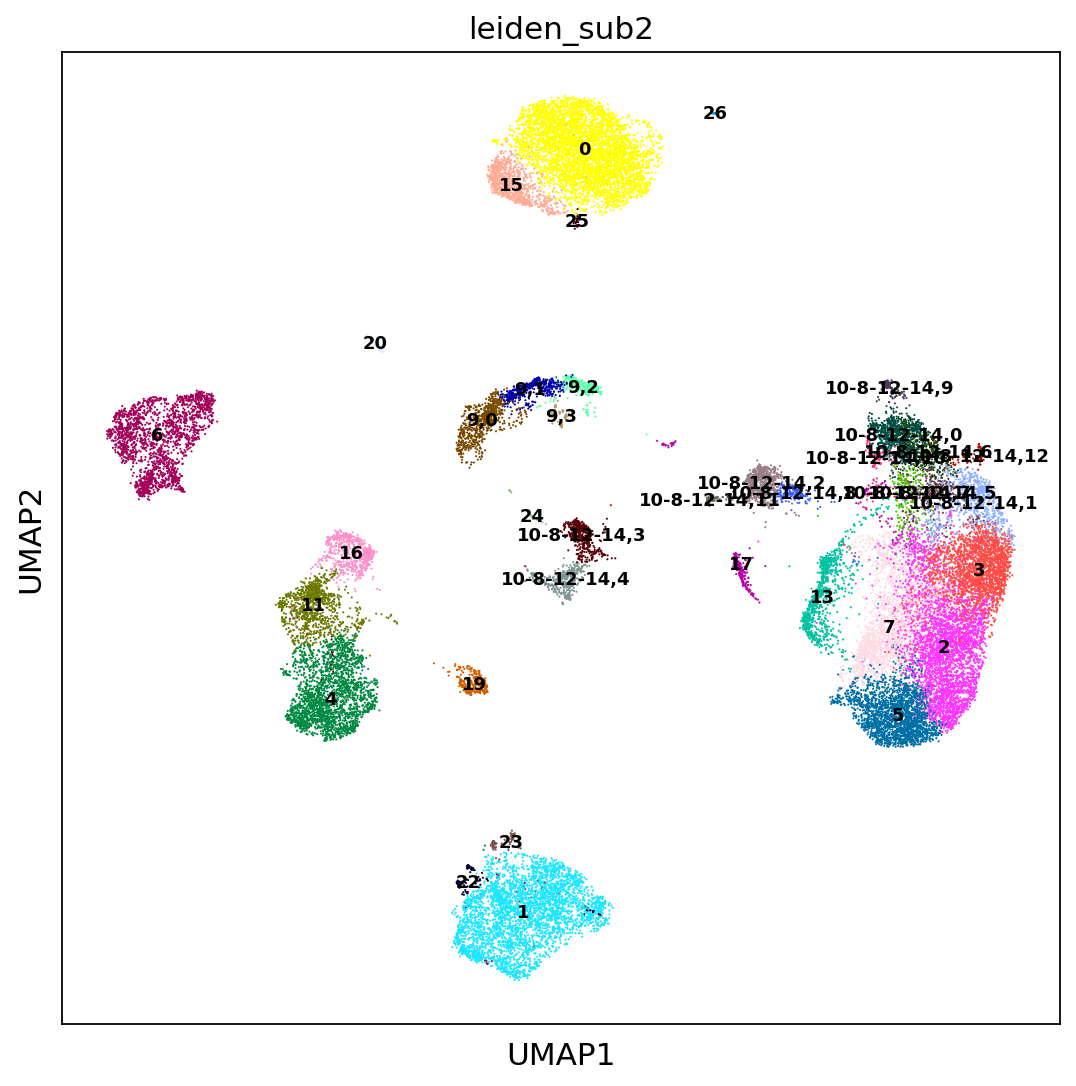

In [37]:
sc.pl.umap(ref_adata, color='leiden_sub2', legend_loc='on data', legend_fontsize='xx-small')

In [76]:
rename_celltype_dict = {
'0': 'memory B cell',
'1': 'fibroblast',
'2': 'CD4-positive, alpha-beta T cell',
'3': 'CD4-positive, alpha-beta T cell',
'4': 'vein endothelial cell',
'5': 'CD4-positive, alpha-beta T cell',
'6': 'vascular associated smooth muscle cell',
'7': 'CD4-positive, alpha-beta T cell',
'9,0': 'plasma cell',
'9,1': 'plasma cell',
'9,2': 'plasma cell',
'9,3': 'Junk',
'11': 'capillary endothelial cell',
'13': 'CD4-positive, alpha-beta T cell',
'15': 'naive B cell',
'16': 'endothelial cell of artery',
'17': 'thymocyte',
'18': 'Junk',
'19': 'endothelial cell of lymphatic vessel',
'20': 'medullary thymic epithelial cell',
'21': 'Junk',
'22': 'fibroblast',
'23': 'fibroblast',
'24': 'neutrophil',
'25': 'memory B cell',
'26': 'plasmacytoid dendritic cell',
"10-8-12-14,0": "CD8-positive, alpha-beta cytotoxic T cell",
"10-8-12-14,1": "CD8-positive, alpha-beta memory T cell",
"10-8-12-14,2": "CD8-positive, alpha-beta T cell",
"10-8-12-14,3": "monocyte",
"10-8-12-14,4": "macrophage",
"10-8-12-14,5": "CD8-positive, alpha-beta memory T cell",
"10-8-12-14,6": "CD8-positive, alpha-beta cytotoxic T cell",
"10-8-12-14,7": "CD8-positive, alpha-beta memory T cell",
"10-8-12-14,8": "naive regulatory T cell",
"10-8-12-14,9": "mature NK T cell",
"10-8-12-14,10": "CD8-positive, alpha-beta cytotoxic T cell",
"10-8-12-14,11": "CD8-positive, alpha-beta T cell",
"10-8-12-14,12": "innate lymphoid cell"}

In [77]:
ref_adata = sc.read('reannotated_thymus.h5ad')

In [78]:
ref_adata.obs['new_cell_ontology_class'] = ref_adata.obs['leiden_sub2'].astype(str)
ref_adata.obs['new_cell_ontology_class'].replace(rename_celltype_dict, inplace=True)

In [79]:
ref_adata = ref_adata[ref_adata.obs['new_cell_ontology_class']!="Junk"].copy()

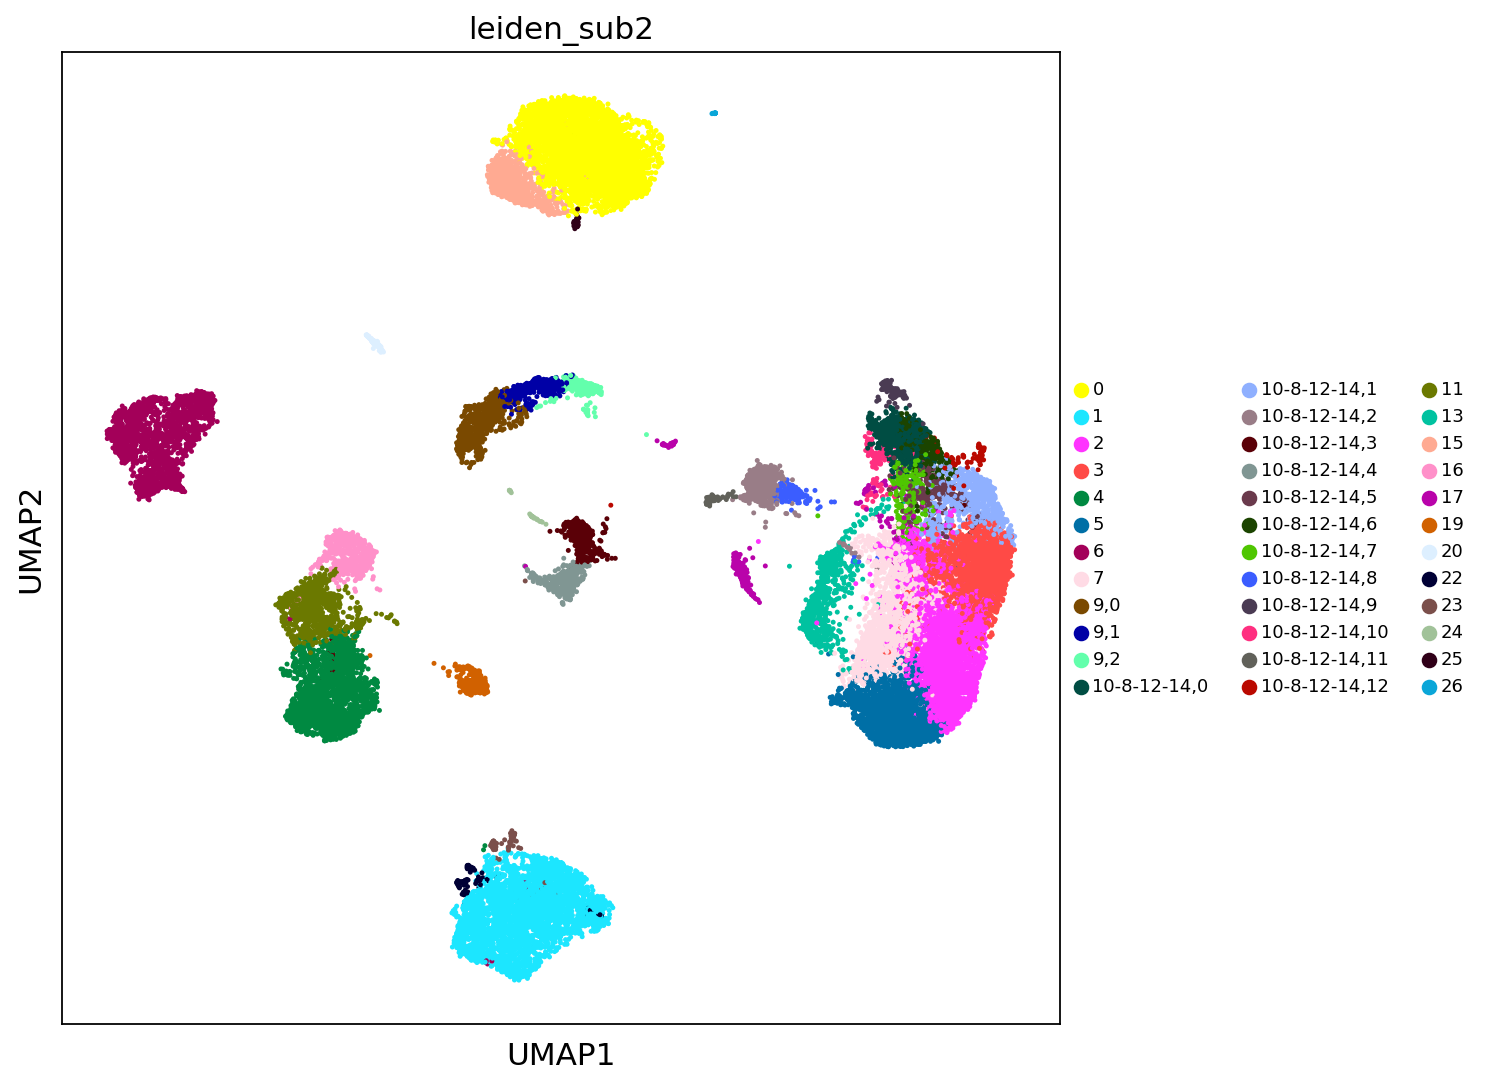

In [80]:
sc.pl.umap(ref_adata, color=['leiden_sub2'], legend_fontsize='xx-small', size=20)

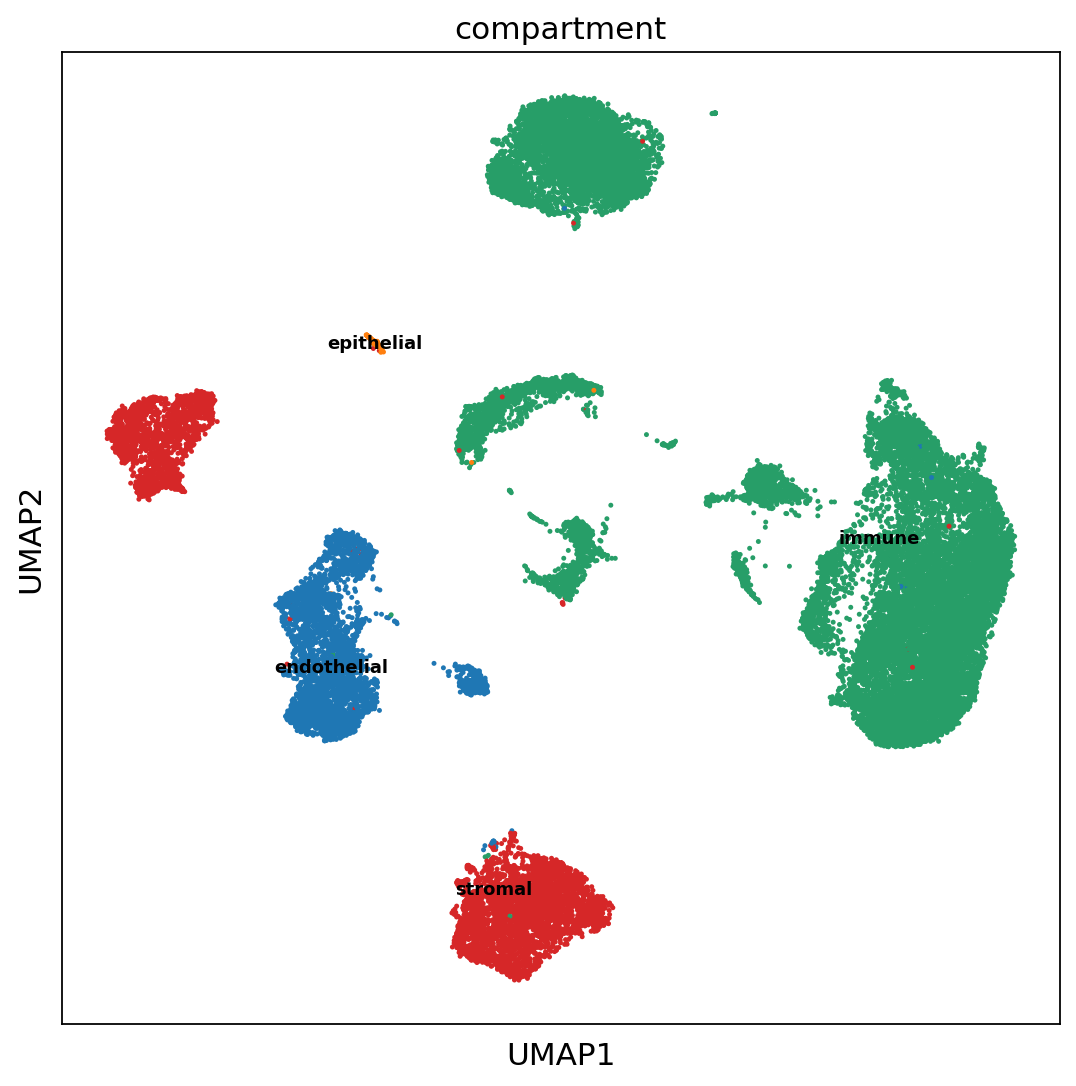

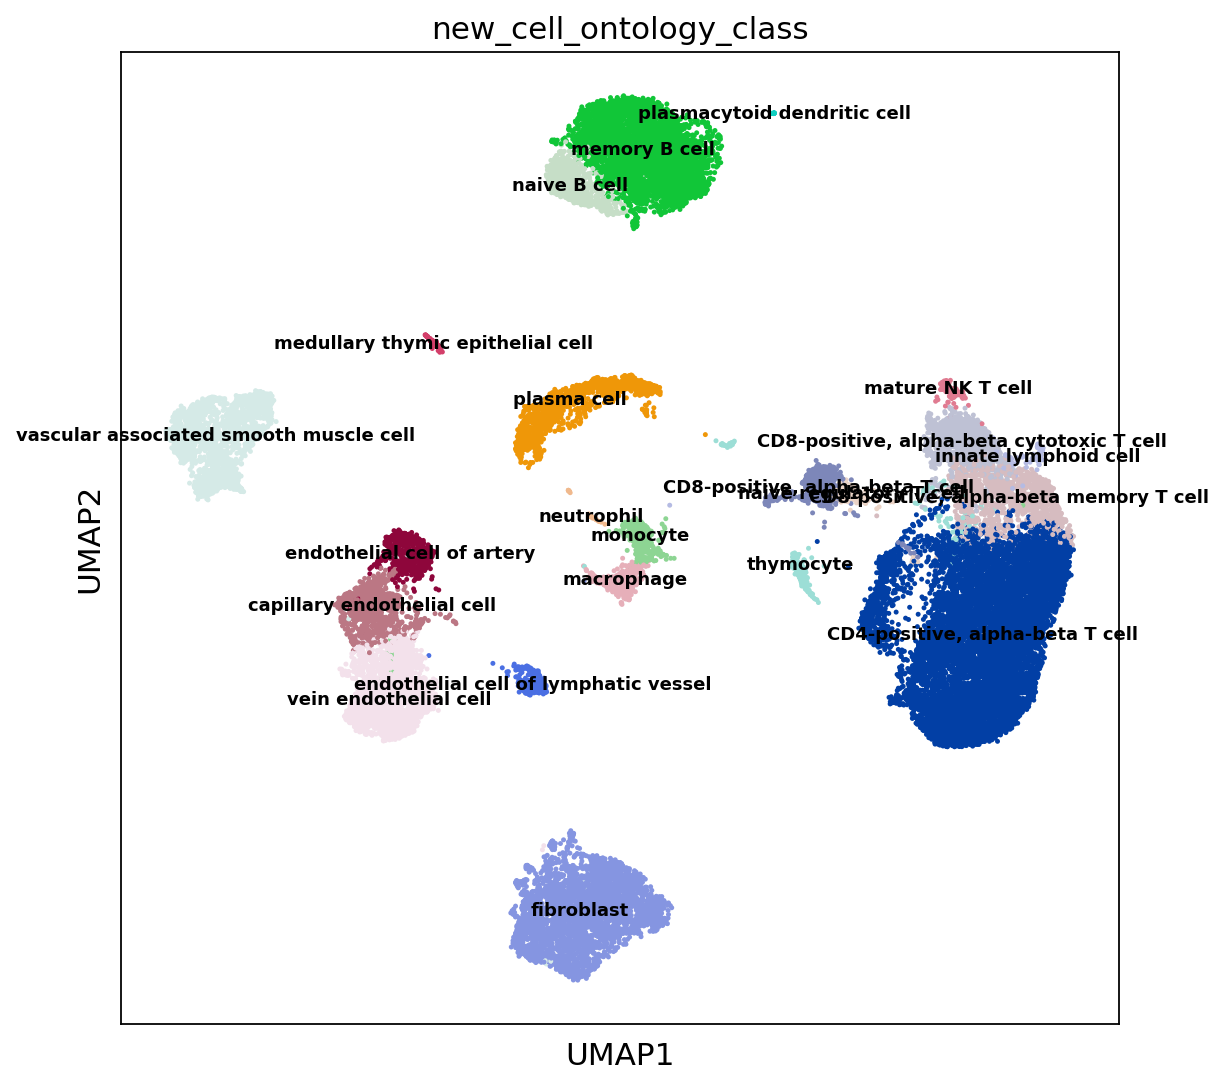

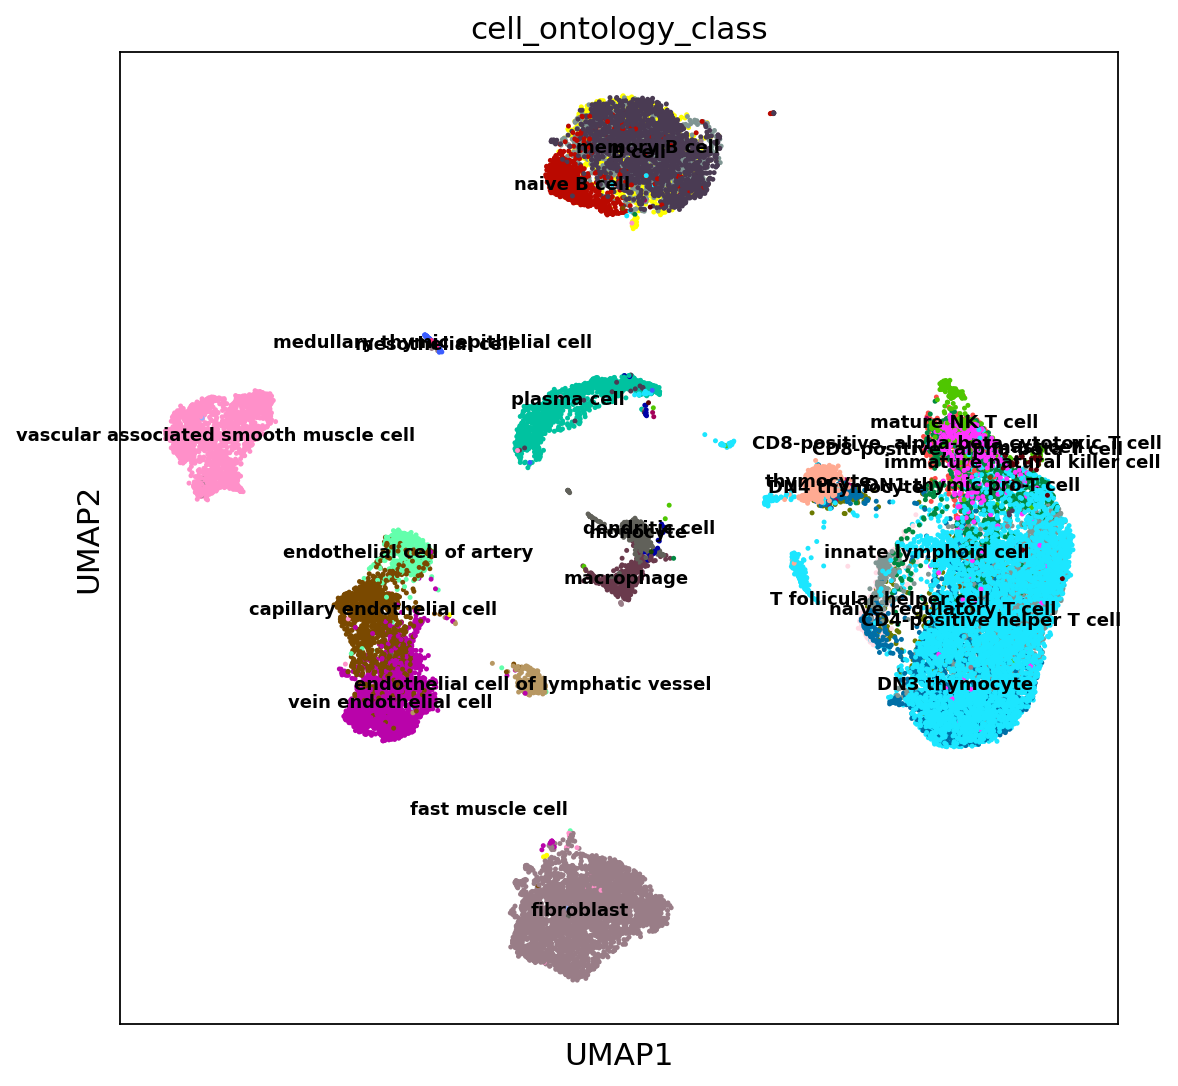

In [81]:
sc.set_figure_params(figsize=[8, 8])
sc.pl.umap(ref_adata, color=['compartment'], legend_loc='on data', legend_fontsize='xx-small', size=20)
sc.pl.umap(ref_adata, color=['new_cell_ontology_class'], legend_loc='on data', legend_fontsize='xx-small', size=20)
sc.pl.umap(ref_adata, color=['cell_ontology_class'], legend_loc='on data', legend_fontsize='xx-small', size=20)

In [82]:
ref_adata.write('reannotated_thymus.h5ad')

In [83]:
reannotated_adata = sc.read('reannotated_thymus.h5ad')
ref_adata = sc.read_h5ad(output_fn)
ref_adata = ref_adata[reannotated_adata.obs_names].copy()

In [84]:
ref_adata.obs['new_cell_ontology_class'] = reannotated_adata.obs['new_cell_ontology_class']

In [85]:
ref_adata.write('Thymus_TS_reannotated.h5ad')

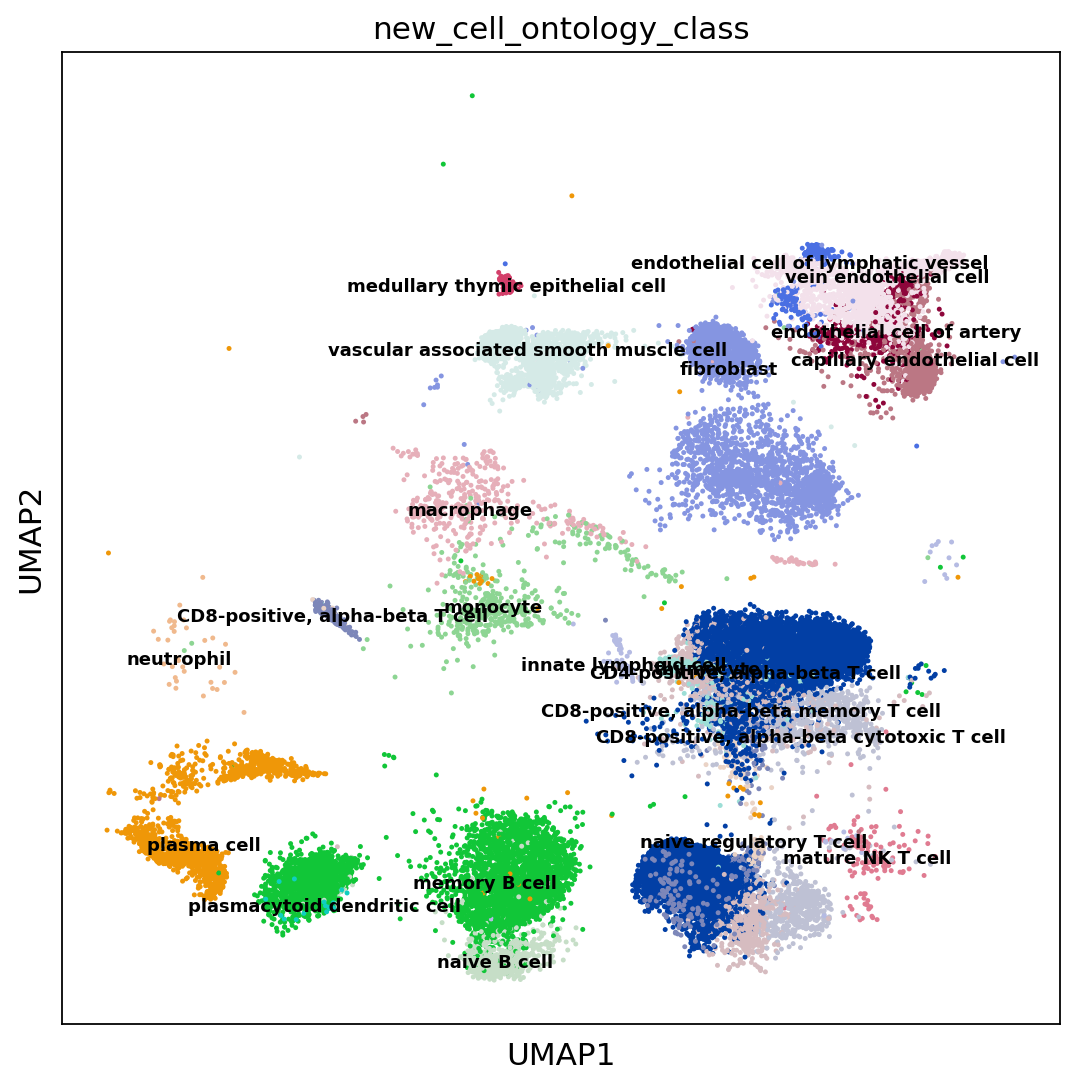

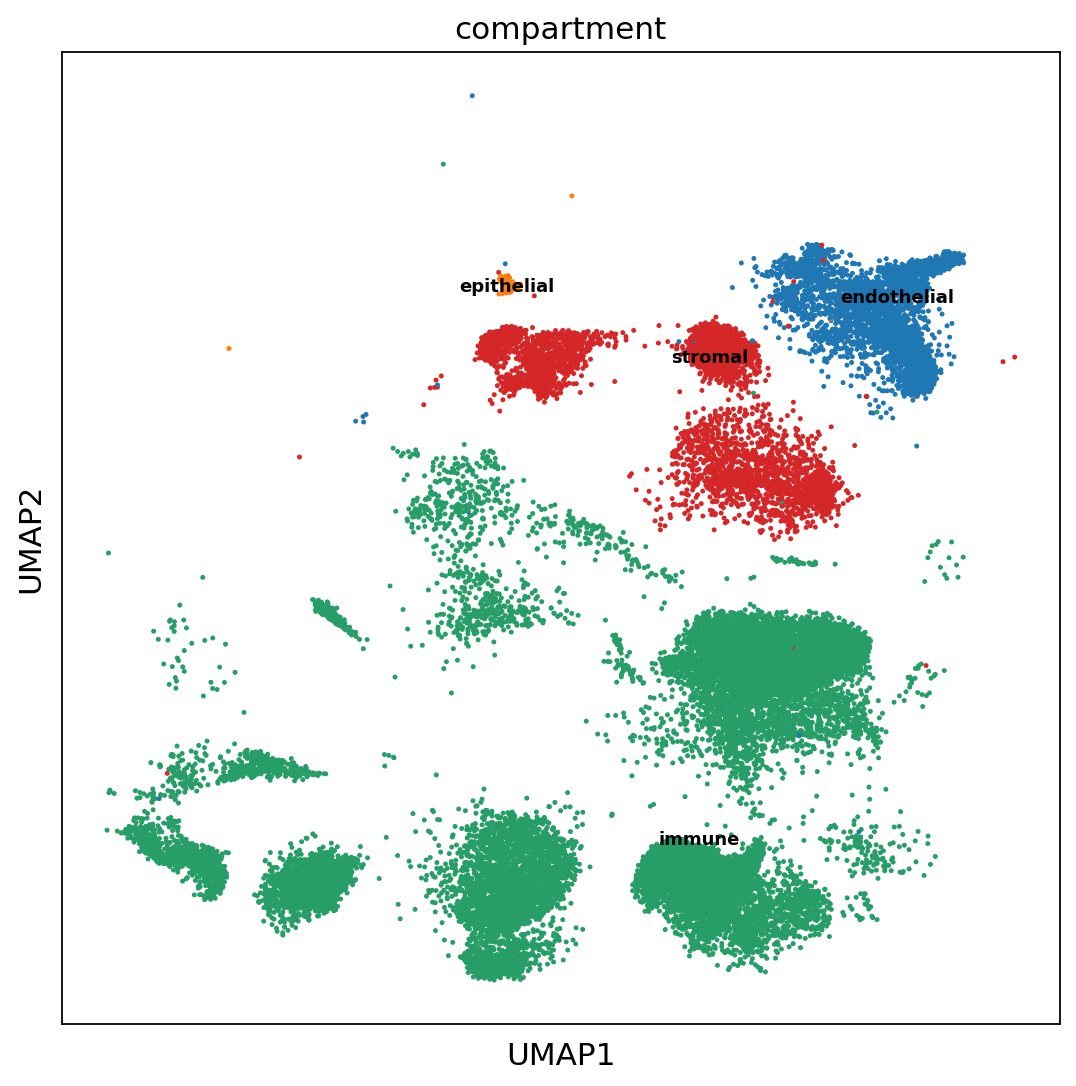

In [86]:
sc.set_figure_params(figsize=[8, 8])
sc.pl.umap(ref_adata, color=['new_cell_ontology_class'], legend_loc='on data', legend_fontsize='xx-small', size=20)
sc.pl.umap(ref_adata, color=['compartment'], legend_loc='on data', legend_fontsize='xx-small', size=20)

In [64]:
ref_adata[ref_adata.obs['new_cell_ontology_class']=='plasma cell'].obs['cell_ontology_class'].value_counts()

plasma cell                               1409
dendritic cell                              15
memory B cell                               13
CD4-positive helper T cell                  12
DN4 thymocyte                                2
medullary thymic epithelial cell             2
vascular associated smooth muscle cell       2
fibroblast                                   1
immature natural killer cell                 1
macrophage                                   1
mature NK T cell                             1
Name: cell_ontology_class, dtype: int64